In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # using this we can make the image of normal folder refer to normal output label and similary for pneumonia folder
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Reshape, Embedding, GlobalAveragePooling1D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
import math
import os
import pandas as pd

In [ ]:

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

print(tf.__version__)

Number of replicas: 1
2.15.0


In [ ]:

train_data_path = '/content/drive/MyDrive/Pnumonia/archive (5)/chest_xray/train'
filepaths = []
labels = []

folds = os.listdir(train_data_path)
for fold in folds:
    foldpath = os.path.join(train_data_path, fold)
    filelist = os.listdir(foldpath)

    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

df = pd.concat([FSeries, LSeries], axis=1)

In [ ]:
df

,filepaths,label
0,/content/drive/MyDrive/Pnumonia/archive (5)/ch...,NORMAL
1,/content/drive/MyDrive/Pnumonia/archive (5)/ch...,NORMAL
2,/content/drive/MyDrive/Pnumonia/archive (5)/ch...,NORMAL
3,/content/drive/MyDrive/Pnumonia/archive (5)/ch...,NORMAL
4,/content/drive/MyDrive/Pnumonia/archive (5)/ch...,NORMAL
...,...,...
5221,/content/drive/MyDrive/Pnumonia/archive (5)/ch...,PNEUMONIA
5222,/content/drive/MyDrive/Pnumonia/archive (5)/ch...,PNEUMONIA
5223,/content/drive/MyDrive/Pnumonia/archive (5)/ch...,PNEUMONIA
5224,/content/drive/MyDrive/Pnumonia/archive (5)/ch...,PNEUMONIA


In [ ]:
valid_data_dir = '/content/drive/MyDrive/Pnumonia/archive (5)/chest_xray/val'
filepaths = []
labels = []

folds = os.listdir(valid_data_dir)
for fold in folds:
    foldpath = os.path.join(valid_data_dir, fold)
    filelist = os.listdir(foldpath)

    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

valid = pd.concat([FSeries, LSeries], axis=1)

In [ ]:

valid

,filepaths,label
0,/content/drive/MyDrive/Pnumonia/archive (5)/ch...,NORMAL
1,/content/drive/MyDrive/Pnumonia/archive (5)/ch...,NORMAL
2,/content/drive/MyDrive/Pnumonia/archive (5)/ch...,NORMAL
3,/content/drive/MyDrive/Pnumonia/archive (5)/ch...,NORMAL
4,/content/drive/MyDrive/Pnumonia/archive (5)/ch...,NORMAL
5,/content/drive/MyDrive/Pnumonia/archive (5)/ch...,NORMAL
6,/content/drive/MyDrive/Pnumonia/archive (5)/ch...,NORMAL
7,/content/drive/MyDrive/Pnumonia/archive (5)/ch...,NORMAL
8,/content/drive/MyDrive/Pnumonia/archive (5)/ch...,PNEUMONIA
9,/content/drive/MyDrive/Pnumonia/archive (5)/ch...,PNEUMONIA


In [ ]:
test_data_dir = '/content/drive/MyDrive/Pnumonia/archive (5)/chest_xray/test'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)

for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)

    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

test = pd.concat([FSeries, LSeries], axis=1)

In [ ]:
test

,filepaths,label
0,/content/drive/MyDrive/Pnumonia/archive (5)/ch...,PNEUMONIA
1,/content/drive/MyDrive/Pnumonia/archive (5)/ch...,PNEUMONIA
2,/content/drive/MyDrive/Pnumonia/archive (5)/ch...,PNEUMONIA
3,/content/drive/MyDrive/Pnumonia/archive (5)/ch...,PNEUMONIA
4,/content/drive/MyDrive/Pnumonia/archive (5)/ch...,PNEUMONIA
...,...,...
619,/content/drive/MyDrive/Pnumonia/archive (5)/ch...,NORMAL
620,/content/drive/MyDrive/Pnumonia/archive (5)/ch...,NORMAL
621,/content/drive/MyDrive/Pnumonia/archive (5)/ch...,NORMAL
622,/content/drive/MyDrive/Pnumonia/archive (5)/ch...,NORMAL


In [ ]:
from sklearn.model_selection import train_test_split
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42)
valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=42)

In [ ]:
# crobed image size
batch_size = 16 * strategy.num_replicas_in_sync
img_size = (180,180)

tr_gen = ImageDataGenerator(rescale = 1./255)
ts_gen = ImageDataGenerator(rescale = 1./255)
val_gen= ImageDataGenerator(rescale = 1./255)

train_dataset = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

val_dataset= val_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_dataset = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 4180 validated image filenames belonging to 2 classes.
Found 523 validated image filenames belonging to 2 classes.
Found 523 validated image filenames belonging to 2 classes.


In [ ]:
# Assuming 'train_dataset' is your dataset object

# Get the shape of the data
data_shape = train_dataset.image_shape
print("Shape of data:", data_shape)


Shape of data: (180, 180, 3)


In [ ]:
# Assuming the class names are 'normal' and 'pneumonia'
class_indices = train_dataset.class_indices


# Count the number of examples for each class
num_normal_examples = sum(1 for label in train_dataset.labels if label == class_indices['NORMAL'])
num_pneumonia_examples = sum(1 for label in train_dataset.labels if label == class_indices['PNEUMONIA'])


print("Number of normal examples:", num_normal_examples)
print("Number of pneumonia examples:", num_pneumonia_examples)

Number of normal examples: 1062
Number of pneumonia examples: 3118


In [ ]:
train_dataset.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [ ]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters,(3,3), activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters,(3,3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D((2,2))
    ]
    )

    return block

In [ ]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block

In [ ]:
def build_model1():
    model1 = tf.keras.Sequential([

        tf.keras.layers.Conv2D(16,(3,3), activation='relu', padding='same',input_shape=(180,180, 3)),
        tf.keras.layers.Conv2D(16,(3,3), activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D((2,2)),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(2, activation='sigmoid') # 2 neural unit not 1
    ])

    return model1

In [ ]:
def build_model2():
    model2 = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(180,180,3)),
        dense_block(32,0.5),
        dense_block(64,0.5),
        dense_block(64,0.5),
        dense_block(128,0.5),
        dense_block(128,0.5),
        dense_block(256,0.5),
        dense_block(256,0.5),
        dense_block(512,0.5),
        dense_block(512,0.5),
        dense_block(1024,0.5),
        tf.keras.layers.Dense(2, activation='sigmoid')
    ])

    return model2


In [ ]:


weight_for_0 = (1 / num_normal_examples)*(num_normal_examples+num_pneumonia_examples)/2.0
weight_for_1 = (1 / num_pneumonia_examples)*(num_normal_examples+num_pneumonia_examples)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.97
Weight for class 1: 0.67


In [ ]:
with strategy.scope():
    model1 = build_model1()
    model2 = build_model2()


    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.BinaryAccuracy(name='f1_score', threshold=0.5)
    ]

    model1.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    model2.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )



In [ ]:
checkpoint_cb1 = tf.keras.callbacks.ModelCheckpoint("xray_model1.keras", save_best_only=True)
checkpoint_cb2 = tf.keras.callbacks.ModelCheckpoint("xray_model2.keras", save_best_only=True)
checkpoint_cb3 = tf.keras.callbacks.ModelCheckpoint("xray_res_model.keras", save_best_only=True)


In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [ ]:
EPOCHS =30
history1 = model1.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    class_weight=class_weight,
    callbacks=[checkpoint_cb1, lr_scheduler],
    shuffle = False,
    verbose= 1
)
history2 = model2.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    class_weight=class_weight,
    callbacks=[checkpoint_cb2, lr_scheduler],
    shuffle = False,
    verbose= 1
)

Epoch 1/20
262/262 [==============================] - 979s 4s/step - loss: 0.4111 - accuracy: 0.8163 - precision: 0.8120 - recall: 0.8110 - f1_score: 0.8116 - val_loss: 0.2884 - val_accuracy: 0.8757 - val_precision: 0.8762 - val_recall: 0.8795 - val_f1_score: 0.8776 - lr: 0.0100
Epoch 2/20
262/262 [==============================] - 304s 1s/step - loss: 0.2515 - accuracy: 0.8959 - precision: 0.8973 - recall: 0.8950 - f1_score: 0.8963 - val_loss: 2.9089 - val_accuracy: 0.4283 - val_precision: 0.4305 - val_recall: 0.4321 - val_f1_score: 0.4302 - lr: 0.0089
Epoch 3/20
262/262 [==============================] - 305s 1s/step - loss: 0.2204 - accuracy: 0.9115 - precision: 0.9118 - recall: 0.9129 - f1_score: 0.9123 - val_loss: 0.2814 - val_accuracy: 0.8776 - val_precision: 0.8776 - val_recall: 0.8776 - val_f1_score: 0.8776 - lr: 0.0079
Epoch 4/20
262/262 [==============================] - 301s 1s/step - loss: 0.1883 - accuracy: 0.9242 - precision: 0.9240 - recall: 0.9244 - f1_score: 0.9242 - v

In [ ]:
!mkdir -p saved model
model1.save('/content/drive/MyDrive/Pnumonia/archive (5)/chest_xray/Saved_model1')
model2.save('/content/drive/MyDrive/Pnumonia/archive (5)/chest_xray/Saved_model2')

In [ ]:
# Evaluate the model on the test set CNN
loss_1, acc_1, prec_1, rec_1, f1_1 = model1.evaluate(test_dataset)

print(f'Test loss: {loss_1}')
print(f'Test accuracy: {acc_1}')
print(f'Test precision: {prec_1}')
print(f'Test recall: {rec_1}')
print(f'Test F1 score: {f1_1}')




33/33 [==============================] - 108s 3s/step - loss: 0.0677 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - f1_score: 0.9771
Test loss: 0.06768707931041718
Test accuracy: 0.9770554304122925
Test precision: 0.9770554304122925
Test recall: 0.9770554304122925
Test F1 score: 0.9770554304122925


In [ ]:
# Evaluate the model on the test set ANN
loss_2, acc_2, prec_2, rec_2, f1_2 = model2.evaluate(test_dataset)

print(f'Test loss: {loss_2}')
print(f'Test accuracy: {acc_2}')
print(f'Test precision: {prec_2}')
print(f'Test recall: {rec_2}')
print(f'Test F1 score: {f1_2}')

33/33 [==============================] - 9s 256ms/step - loss: 0.1744 - accuracy: 0.9407 - precision: 0.9407 - recall: 0.9407 - f1_score: 0.9407
Test loss: 0.17437484860420227
Test accuracy: 0.9407265782356262
Test precision: 0.9407265782356262
Test recall: 0.9407265782356262
Test F1 score: 0.9407265782356262


EPOCHS = 15

history1 = model1.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[checkpoint_cb1, lr_scheduler]
)

history2 = model2.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[checkpoint_cb2, lr_scheduler]
)

history3 = model3.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[checkpoint_cb3, lr_scheduler]
)


In [ ]:
IMAGE_SIZE = (224, 224)
# Default batch size
BATCH_SIZE = 32

In [ ]:
Image_gen = ImageDataGenerator(
        rescale = 1/255,
        shear_range=10,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.5,2.0],
        width_shift_range = 0.2,
        rotation_range=20,
        fill_mode = 'nearest'
)
val_Datagen = ImageDataGenerator(
        rescale = 1/255
)

In [ ]:
# crobed image size
batch_size = 16 * strategy.num_replicas_in_sync
img_size = (180,180)

tr_gen = ImageDataGenerator(rescale = 1./255)
ts_gen = ImageDataGenerator(rescale = 1./255)
val_gen= ImageDataGenerator(rescale = 1./255)

train_dataset = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

val_dataset= val_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_dataset = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

In [ ]:
train_directory = '/content/drive/MyDrive/Pnumonia/archive (5)/chest_xray/train'
val_directory = '/content/drive/MyDrive/Pnumonia/archive (5)/chest_xray/val'
test_directory = '/content/drive/MyDrive/Pnumonia/archive (5)/chest_xray/test'

train = Image_gen.flow_from_directory(train_directory,
                                       batch_size=32,
                                       class_mode='binary',
#                                        target_size=(224,224,3))
                                       )

validation = Image_gen.flow_from_directory(val_directory,
                                              batch_size=2,
                                              class_mode='binary',
#                                               target_size=(224,224,3))
                                            )

test = val_Datagen.flow_from_directory(test_directory,
                                       batch_size=2,
                                       class_mode='binary',
#                                        target_size=(224/,224,3))
                                      )

Found 5226 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                          patience=8)

In [ ]:
def create_model():
    resnet_model = tf.keras.applications.ResNet50V2(
        weights='imagenet',
        include_top = False,
        input_shape = (224,224,3)
    )

    for layer in resnet_model.layers:
        layer.trainable=False

    x = resnet_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128,activation='relu')(x)
    # output layer
    predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)

    res_model = tf.keras.Model(inputs=resnet_model.input, outputs=predictions)

    # Compiling the model
    res_model.compile(loss='binary_crossentropy', optimizer='adam',metrics=METRICS)
    return res_model

In [ ]:

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.BinaryAccuracy(name='f1_score', threshold=0.5)
    ]

In [ ]:
res_model = create_model()

94668760/94668760 [==============================] - 1s 0us/step


In [ ]:
res_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                              

In [ ]:
history = res_model.fit(train,epochs=30,
                    steps_per_epoch=len(train) // 16,
                    validation_data=validation,
                    class_weight=class_weight,
                    validation_steps=len(validation) // 2,
                    callbacks=[checkpoint_cb3,early_stopping,lr],
                    batch_size=32)

In [ ]:
res_model.save('/content/drive/MyDrive/Pnumonia/archive (5)/chest_xray/Saved_res_model')

In [ ]:
# Evaluate the model on the test set RESNET50
loss_3, acc_3, prec_3, rec_3, f1_3  = res_model.evaluate(test)

print(f'Test loss: {loss_3}')
print(f'Test accuracy: {acc_3}')
print(f'Test precision: {prec_3}')
print(f'Test recall: {rec_3}')
print(f'Test F1 score: {f1_3}')


In [ ]:
import pandas as pd

# Define the metrics for each model
metrics_data = {
    'Model': ['CNN', 'ANN', 'RESNET50'],
    'Loss': [loss_1, loss_2, loss_3],
    'Accuracy': [acc_1, acc_2, acc_3],
    'Precision': [prec_1, prec_2, prec_3],
    'Recall': [rec_1, rec_2, rec_3],
    'F1 Score': [f1_1, f1_2, f1_3]
}

# Create a DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Display the DataFrame
print(metrics_df)


In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.models import Input, Average

m1= load_model('/content/drive/MyDrive/Pnumonia/archive (5)/chest_xray/Saved_res_model1')
m1= Model(inputs=m1.inputs,output=m1.outputs,name='CNN')

m2= load_model('/content/drive/MyDrive/Pnumonia/archive (5)/chest_xray/Saved_model2')
m2= Model(inputs=m2.inputs,output=m2.outputs,name='ANN')


m3= load_model('/content/drive/MyDrive/Pnumonia/archive (5)/chest_xray/Saved_res_model')
m3= Model(inputs=m3.inputs,output=m3.outputs,name='ResNet50')
models[m1,m2,m3]


In [ ]:
models = [m1,m2,m3]
model_input = tf.keras.Input(shape=(224,224,3))
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model = tf.keras.Model(inputs= model_input, outputs= ensemble_output)


In [ ]:
ensemble_model.compile(
    optimizer = 'adam',
    loss=tf,losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=METRICS

)

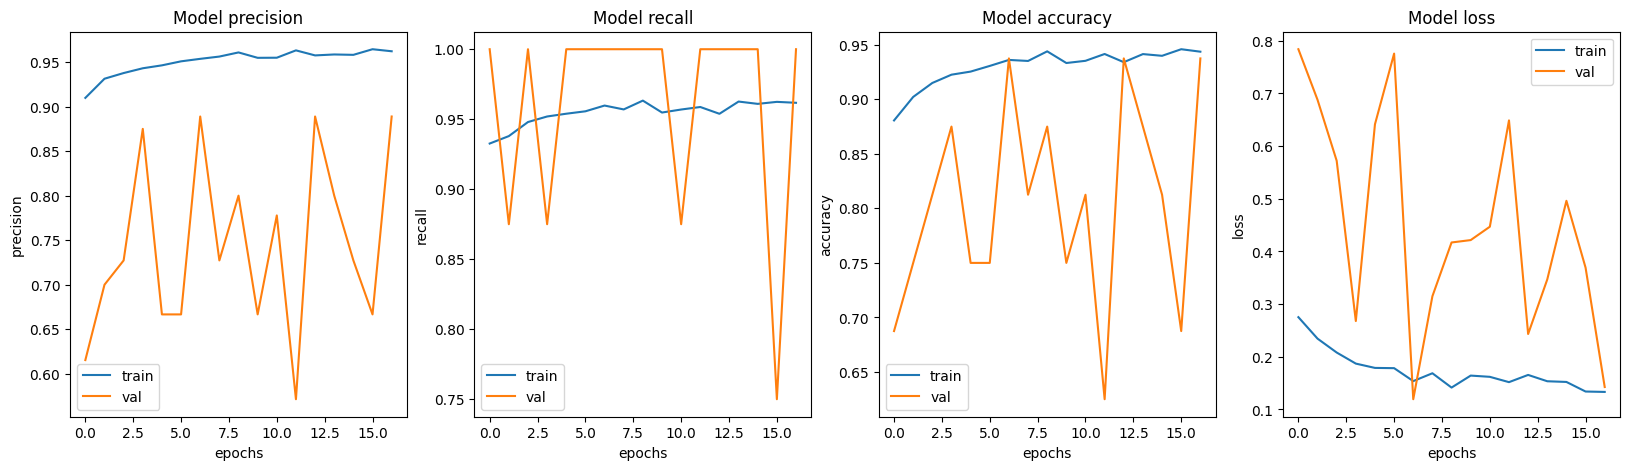

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20,5))
ax = ax.ravel()
for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
tr_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

In [ ]:
def create_ensemble(model1, model2, model3):
    input_layer = tf.keras.Input(shape=(180,180,3))
    resnet_input_layer = tf.keras.Input(shape=(224,224,3))

    resnet_output = model3(resnet_input_layer)
    cnn_output = model1(input_layer)
    ann_output = model2(input_layer)

    resnet_weight = 0.2
    cnn_weight = 0.5
    ann_weight = 0.3

    x = resnet_weight * resnet_output + cnn_weight * cnn_output + ann_weight * ann_output
    output = tf.keras.layers.Dense(2, activation='softmax')(x)

    ensemble_model = tf.keras.Model(inputs=[input_layer, resnet_input_layer], outputs=output)
    ensemble_model

In [ ]:
# Cropped image size
batch_size = 16 * strategy.num_replicas_in_sync
img_size = (180, 180)

# Define image data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Define base directory
base_dir = '/content/drive/MyDrive/Pnumonia/archive (5)/chest_xray/'

# Define train, validation, and test datasets using flow_from_dataframe
train_dataset = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepaths',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

val_dataset = val_gen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='filepaths',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

test_dataset = ts_gen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepaths',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)